In [1]:
import numpy as np
import ase.db
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import math
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import seaborn as sns
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import sklearn.gaussian_process as gp
import random

# Adsorption Energy Model

In [2]:
x = np.loadtxt("../2_feature/feature.csv", delimiter=",",encoding='utf-8-sig')
y = np.loadtxt("../2_feature/energy.csv", delimiter=",",encoding='utf-8-sig')

In [3]:
kernel = gp.kernels.ConstantKernel(constant_value=1,constant_value_bounds=(1e-1,1e3)) *gp.kernels.RBF(length_scale=10, length_scale_bounds=(1e-1, 1e3))
gpr_model = gp.GaussianProcessRegressor(kernel=kernel,
                                        n_restarts_optimizer=50,
                                        alpha=0.1,
                                        normalize_y=True)

In [4]:
standardscaler = StandardScaler()
pca = PCA(0.99)
MAE_TRAIN = []
R2_TRAIN = []
MAE_TEST = []
R2_TEST = []

for i in range(0,10):
    x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.8,test_size=0.2, random_state=i)
    standardscaler = StandardScaler()
    pca = PCA(0.99)
    X_train = standardscaler.fit_transform(x_train)
    X_train = pca.fit_transform(X_train)
    print('x_train shape after PCA:',X_train.shape)
    X_test = standardscaler.transform(x_test)
    X_test = pca.transform(X_test)  
    gpr_model.fit(X_train, y_train)
    y_train_predict=gpr_model.predict(X_train)
    y_test_predict=gpr_model.predict(X_test)
    MAE_train = mean_absolute_error(y_pred=y_train_predict, y_true=y_train)
    R2_train = r2_score(y_pred=y_train_predict, y_true=y_train)
    MAE_test = mean_absolute_error(y_pred=y_test_predict, y_true=y_test)
    R2_test = r2_score(y_pred=y_test_predict, y_true=y_test)
    MAE_TRAIN.append(MAE_train)
    MAE_TEST.append(MAE_test)
    R2_TRAIN.append(R2_train)
    R2_TEST.append(R2_test)
    
print('MAE train:',np.mean(MAE_TRAIN),'R2 train:',np.mean(R2_TRAIN))
print('MAE train:',np.mean(MAE_TEST),'R2 train:',np.mean(R2_TEST))

x_train shape after PCA: (112, 9)
x_train shape after PCA: (112, 9)
x_train shape after PCA: (112, 9)
x_train shape after PCA: (112, 9)
x_train shape after PCA: (112, 9)
x_train shape after PCA: (112, 9)
x_train shape after PCA: (112, 9)
x_train shape after PCA: (112, 9)
x_train shape after PCA: (112, 9)
x_train shape after PCA: (112, 9)
MAE train: 0.034832090390547424 R2 train: 0.9639281600636382
MAE train: 0.060522128901621695 R2 train: 0.8846425880891717


x_train shape after PCA: (112, 9)
MAE train: 0.03194812981286794 R2 train: 0.9664544658882633
MAE test: 0.06117459778653752 R2 test: 0.9186622965051697


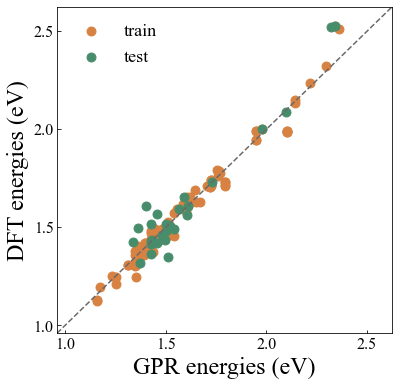

In [6]:
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.8, test_size=0.2, random_state=3)
standardscaler = StandardScaler()
pca = PCA(0.99)
X_train = standardscaler.fit_transform(x_train)
X_train = pca.fit_transform(X_train)
print('x_train shape after PCA:',X_train.shape)
X_test = standardscaler.transform(x_test)
X_test = pca.transform(X_test)  
gpr_model.fit(X_train, y_train)
y_train_predict=gpr_model.predict(X_train)
y_test_predict=gpr_model.predict(X_test)
MAE_train = mean_absolute_error(y_pred=y_train_predict, y_true=y_train)
R2_train = r2_score(y_pred=y_train_predict, y_true=y_train)
MAE_test = mean_absolute_error(y_pred=y_test_predict, y_true=y_test)
R2_test = r2_score(y_pred=y_test_predict, y_true=y_test)


print('MAE train:',MAE_train,'R2 train:',R2_train)
print('MAE test:',MAE_test,'R2 test:',R2_test)

# Make the joint plot
plt.rc('font',family='Times New Roman')
plt.rcParams['xtick.direction']='in'
plt.rcParams['ytick.direction']='in'

xmin=min(y_train_predict)-0.2
xmax=max(y_train_predict)+0.2
x_lim=np.linspace(xmin,xmax,20)

fig,ax=plt.subplots(figsize=(6,6))
plt.xlim([xmin,xmax])
plt.ylim([xmin,xmax])
plt.xticks([1.0, 1.5, 2.0, 2.5])
plt.yticks([1.0, 1.5, 2.0, 2.5])

plt.scatter(y_train_predict,y_train,color='#D78242', s=80)
plt.scatter(y_test_predict, y_test, color='#488D6B', s=80)
plt.legend(['train','test'],fontsize=18,frameon=False)
plt.plot(x_lim,x_lim,linestyle='--',color='dimgray')
plt.tick_params(labelsize=16)

plt.xlabel('GPR energies (eV)',fontsize=24)
plt.ylabel('DFT energies (eV)',fontsize=24)
plt.savefig('parity plot.png',dpi=1000)

In [7]:
# save gpr model and preprocessing model 
import pickle
from sklearn.pipeline import Pipeline

s = pickle.dumps(gpr_model)
with open('GPRmodel.model','wb+') as f:
    f.write(s)
    
steps = [('scaler', standardscaler),('pca', pca)]
pipeline = Pipeline(steps)
with open('Preprocessing.pkl', 'wb+') as f:
    pickle.dump(pipeline, f)